# Digital Signal and Image Processing Project - Image Super-Resolution

#Imports

In [1]:
from google.colab import drive
import zipfile
import shutil
from skimage import io

from matplotlib import pyplot as plt
import numpy as np
import os
import math
import cv2

import random as python_random
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from skimage.transform import resize

import warnings

np.random.seed(0)
python_random.seed(0)
tf.random.set_seed(0)
keras.utils.set_random_seed(0)
cv2.setRNGSeed(0)
drive.mount('/content/drive')

Mounted at /content/drive


# Dataset creation

In this first section the dataset is extracted, augmented and divided into train, val and test sets that get saved on specific folders in colab's runtime, to optimize the RAM usage (keeping everything loaded in a variable would use way too much RAM), and just import them later in batches when needed for training/validation/testing.

The dataset zip file is copied in the runtime, extracted and deleted.

In [2]:
# Link Google Drive account, transfer dataset, and extract files
shutil.copy('/content/drive/My Drive/ImageSuperResolutionDatasetSmall.zip', 'ImageSuperResolutionDatasetSmall.zip')
zipf = zipfile.ZipFile('ImageSuperResolutionDatasetSmall.zip')
zipf.extractall()
zipf.close()

os.remove('ImageSuperResolutionDatasetSmall.zip') # Delete the copied zip file

The split_image() function takes an image as input and returns a list of images. It splits the given image into patches of target_size, overlapping so that every part of the original image is at least in one patch. The number of returned images varies based on the image's size and the target_size of each patch.

In [3]:
def split_image(image, target_size=(1000, 1000)):
    h, w, _ = image.shape
    target_h, target_w = target_size
    #print(w, h)

    # If the image is smaller than the target size, discard the image
    if h <= target_h or w <= target_w:
        #print(f"The image size ({h}, {w}) is smaller than the target size ({target_h}, {target_w}), discarding image.")
        return None

    cropped_images = [] # List to store the cropped images

    # Calculates the amount of images per axis
    tot_images_x = math.ceil(w/target_w)
    tot_images_y = math.ceil(h/target_h)

    # Calculates the amount of sliding per axis, so that each cropped image is as far as possible to the others and the amount of overlappings are equally distributed
    slide_w=int(w/tot_images_x)
    slide_h=int(h/tot_images_y)

    # Extracts the patches
    for j in range(tot_images_y):
        for i in range(tot_images_x):
            start_w = slide_w * i
            start_h = slide_h * j
            if(start_w + target_w > w):
                start_w = w-target_w
            if(start_h + target_h > h):
                start_h = h - target_h

            end_w = start_w + target_w
            end_h = start_h + target_h
            #print(start_w, end_w, start_h, end_h)

            cropped = image[start_h:end_h, start_w:end_w]
            #print("shape:", cropped.shape)
            cropped_images.append(cropped)

    # Converts the list of cropped images to a NumPy array
    return cropped_images

The create_dataset funciton takes as input the source path of the dataset, the destination paths to put the training and validation sets, the target size of the patches to divide each image of the dataset in, and the split ratio between trainining and validation set.

This also works to create the test set, by just leaving the second path empty and using a split ratio of 1.

In [4]:
def create_dataset(source_path, destination_path_train, destination_path_validation, image_target_size, split=0.75):
    imported_image_count = 0
    augmented_image_count = 0

    # Calculates the train/val split
    tot_images_in_dataset = len(os.listdir(source_path))
    train_index_max = int(tot_images_in_dataset * split)

    start_index = 0
    max_index = len(os.listdir(source_path))
    file_paths = sorted(os.listdir(source_path))

    for i in range(start_index, max_index):
        if(i < train_index_max):
            destination_path = destination_path_train
        else:
            destination_path = destination_path_validation

        filename = os.listdir(source_path)[i]
        if filename.endswith(('.jpg', '.jpeg', '.png')):
            image_path = os.path.join(source_path, filename)
            #print("Importing", filename)
            image = io.imread(image_path)
            split_images = split_image(image, image_target_size)

            if split_images is not None:
                # Create subfolders in train/val folder
                for j, cropped_image in enumerate(split_images):
                    # Generate a new filename for each cropped image (to avoid overwriting)
                    new_filename = f"{os.path.splitext(filename)[0]}_split_{i}_{j}.jpg"
                    save_path = os.path.join(destination_path, new_filename)

                    # Save the cropped image
                    io.imsave(save_path, cropped_image)
                augmented_image_count += len(split_images)

            imported_image_count += 1

    return imported_image_count, augmented_image_count  # Return the number of imported images and augmented images

This suppresses some warnings, about when images with low contrast are saved (for example patches that only include the sky).

Although this patches do not provide the model with much information during the training, I believe it is still very important to include them so that the inference phase can work properly.

In [5]:
warnings.filterwarnings("ignore", category=UserWarning, module="skimage")

This uses the previous functions to divide the dataset into train, val and test sets, while augmenting each input image using the split_image function.

Each patch is saved on a distinct folder on the disk (for ram optimization) and is of size 256x256.

If the images have already been extracted and augmented, this phase is skipped (useful to speed up re-executions of the entire notebook).

In [6]:
source_path = "ImageSuperResolutionDatasetSmall/training"
train_path_destination = "dataset/train"
val_path_destination = "dataset/val"
target_size = (256, 256)
train_val_split = 0.80

# Check if the destination folders exist, if not, create them
if not os.path.exists(train_path_destination):
    os.makedirs(train_path_destination)
    os.makedirs(val_path_destination)
    imported_image_count, augmented_image_count = create_dataset(source_path, train_path_destination, val_path_destination, target_size, split=train_val_split)
    print("Train/val dataset created.")
    print(f"Imported images: {imported_image_count}")
    print(f"Augmented images: {augmented_image_count}")
else:
    print("Destination folders already exist. The dataset probably already exists.")

Train/val dataset created.
Imported images: 100
Augmented images: 4744


In [7]:
print("Train images:", len(os.listdir("dataset/train")))
print("Val images:", len(os.listdir("dataset/val")))

Train images: 3816
Val images: 928


In [8]:
source_path = "ImageSuperResolutionDatasetSmall/test"
test_path_destination = "dataset/test"

if not os.path.exists(test_path_destination):
    os.makedirs(test_path_destination)
    imported_image_count, augmented_image_count = create_dataset(source_path, test_path_destination, "", target_size, split=1)
    print("Test dataset created.")
    print(f"Imported images: {imported_image_count}")
    print(f"Augmented images: {augmented_image_count}")
else:
    print("Destination folders already exist. The dataset probably already exists.")

Test dataset created.
Imported images: 50
Augmented images: 2344


In [9]:
print("Test images:", len(os.listdir("dataset/test")))

Test images: 2344


## Example of split_image()

This example shows how the image is split in 4 1000x1000 patches (that can overlap by design), 1000x1000 is the default patch size.

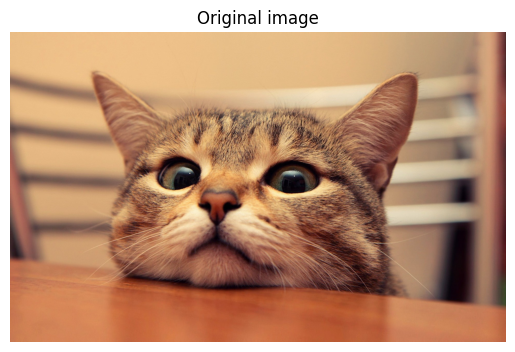

In [10]:
example_image = io.imread('/content/drive/My Drive/cat.jpg')

plt.imshow(example_image)
plt.title("Original image")
plt.axis('off')
plt.show()

In [11]:
example_image.shape

(1200, 1920, 3)

In [12]:
example_images = split_image(example_image)

if example_images is not None:
    print("Number of segments:", len(example_images))
    for i, segment in enumerate(example_images):
        print(f"Shape of segment {i}:", segment.shape)

Number of segments: 4
Shape of segment 0: (1000, 1000, 3)
Shape of segment 1: (1000, 1000, 3)
Shape of segment 2: (1000, 1000, 3)
Shape of segment 3: (1000, 1000, 3)


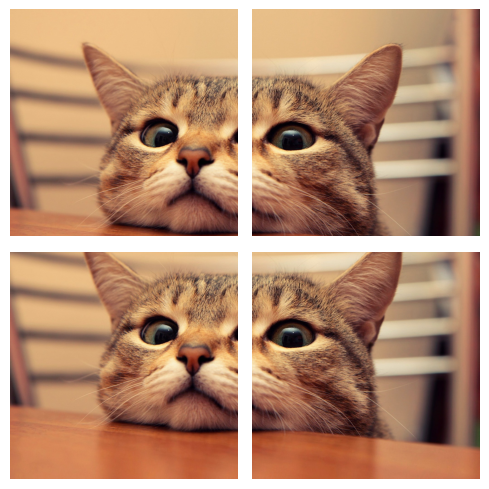

In [13]:
# Plot the 4 split images
fig, axes = plt.subplots(2, 2, figsize=(5, 5))

# Plot each image in a subplot
axes[0, 0].imshow(example_images[0])
axes[0, 0].axis('off')  # Turn off axis ticks and labels
axes[0, 1].imshow(example_images[1])
axes[0, 1].axis('off')
axes[1, 0].imshow(example_images[2])
axes[1, 0].axis('off')
axes[1, 1].imshow(example_images[3])
axes[1, 1].axis('off')

plt.tight_layout()
plt.show()

In this example the image is split in 12 because it's bigger, the patches are still 1000x1000. This shows the flexibility of the function, when the image has a different size.

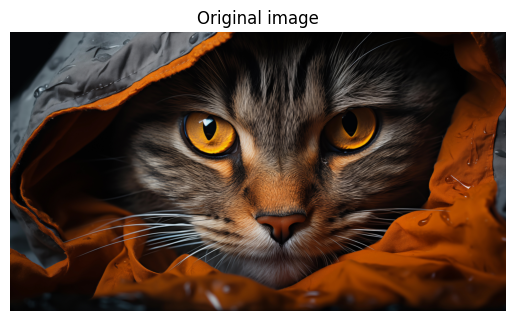

In [14]:
example_image = io.imread('/content/drive/My Drive/high_res_cat.jpg')

plt.imshow(example_image)
plt.title("Original image")
plt.axis('off')
plt.show()

In [15]:
example_image.shape

(2160, 3840, 3)

In [16]:
example_images = split_image(example_image)

if example_images is not None:
    print("Number of segments:", len(example_images))
    for i, segment in enumerate(example_images):
        print(f"Shape of segment {i}:", segment.shape)

Number of segments: 12
Shape of segment 0: (1000, 1000, 3)
Shape of segment 1: (1000, 1000, 3)
Shape of segment 2: (1000, 1000, 3)
Shape of segment 3: (1000, 1000, 3)
Shape of segment 4: (1000, 1000, 3)
Shape of segment 5: (1000, 1000, 3)
Shape of segment 6: (1000, 1000, 3)
Shape of segment 7: (1000, 1000, 3)
Shape of segment 8: (1000, 1000, 3)
Shape of segment 9: (1000, 1000, 3)
Shape of segment 10: (1000, 1000, 3)
Shape of segment 11: (1000, 1000, 3)


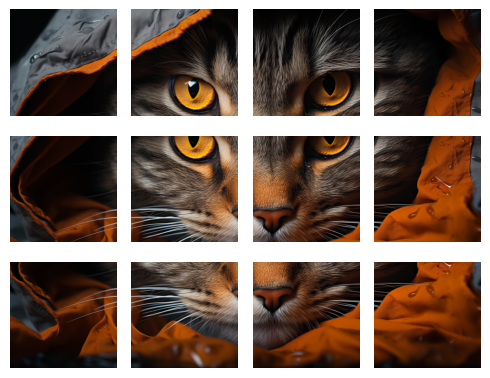

In [17]:
# Plot the 12 split images
fig, axes = plt.subplots(3, 4, figsize=(5, 4))

axes = axes.flatten()

# Plot each image in a subplot
for i in range(len(example_images)):  # Loop through all 12 images
    axes[i].imshow(example_images[i])
    axes[i].axis('off')  # Turn off axis ticks and labels

plt.tight_layout()
plt.show()

Lastly, this example shows how the patches size can be customized.

In [18]:
example_images = split_image(example_image, target_size=(256,256))

if example_images is not None:
    print("Number of segments:", len(example_images))
    for i, segment in enumerate(example_images):
        print(f"Shape of segment {i}:", segment.shape)

Number of segments: 135
Shape of segment 0: (256, 256, 3)
Shape of segment 1: (256, 256, 3)
Shape of segment 2: (256, 256, 3)
Shape of segment 3: (256, 256, 3)
Shape of segment 4: (256, 256, 3)
Shape of segment 5: (256, 256, 3)
Shape of segment 6: (256, 256, 3)
Shape of segment 7: (256, 256, 3)
Shape of segment 8: (256, 256, 3)
Shape of segment 9: (256, 256, 3)
Shape of segment 10: (256, 256, 3)
Shape of segment 11: (256, 256, 3)
Shape of segment 12: (256, 256, 3)
Shape of segment 13: (256, 256, 3)
Shape of segment 14: (256, 256, 3)
Shape of segment 15: (256, 256, 3)
Shape of segment 16: (256, 256, 3)
Shape of segment 17: (256, 256, 3)
Shape of segment 18: (256, 256, 3)
Shape of segment 19: (256, 256, 3)
Shape of segment 20: (256, 256, 3)
Shape of segment 21: (256, 256, 3)
Shape of segment 22: (256, 256, 3)
Shape of segment 23: (256, 256, 3)
Shape of segment 24: (256, 256, 3)
Shape of segment 25: (256, 256, 3)
Shape of segment 26: (256, 256, 3)
Shape of segment 27: (256, 256, 3)
Shape 

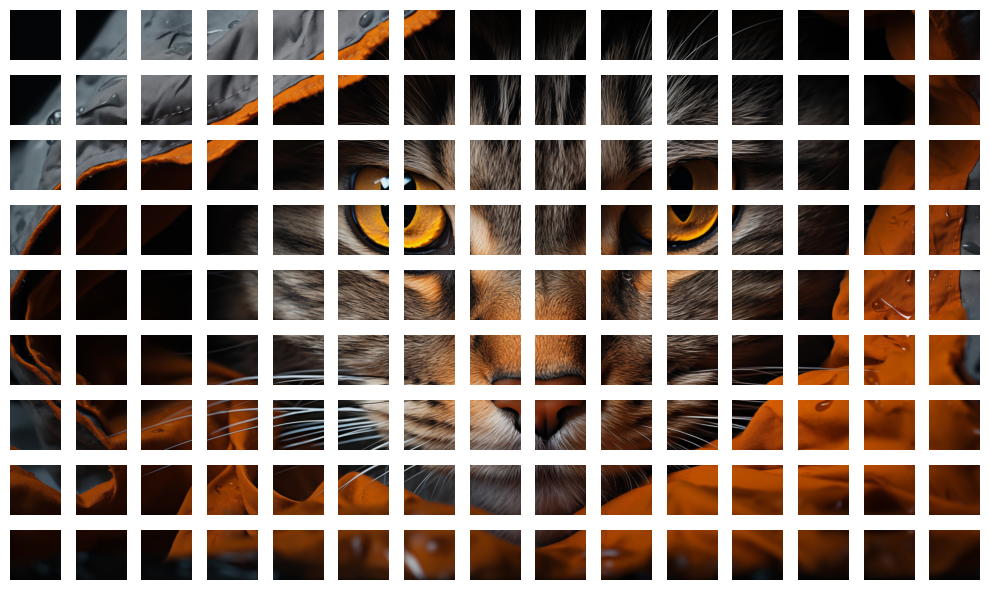

In [19]:
# Plot the split images
fig, axes = plt.subplots(9, 15, figsize=(10, 6))

axes = axes.flatten()

# Plot each image in a subplot
for i in range(len(example_images)):  # Loop through all 12 images
    axes[i].imshow(example_images[i])
    axes[i].axis('off')  # Turn off axis ticks and labels

plt.tight_layout()
plt.show()

# SRCNN (Super Resolution Convolutional Neural Network)

## First SRCNN model

The first model takes as input patches of size 33x33 (like in the original paper) and outputs the same size. The input images are downscaled with a scale of 2 times, and then upscaled back to 33x33.

### Functions

The SRCNN model takes inspiration from the original paper.

The input is the low resolution image, upscaled by the same factor it was downscaled with, to match the output size of the original image (patch). The model takes the 3 RGB channels as input. The alternative was to convert the image into YCbCr but the paper shows how keeping the image RGB works better because of the correlation between channels.

The first layer applies 64 convolution filters of size 9x9 to the input image. The goal of this layer is to capture the image's features representations.

The second layer learns a non-linear transformation of the features extracted from the first layer, capturing more complex patterns and dependencies. This works with a dimensionality reduction of feature maps and the number of parameters, enabling efficient learning and reconstruction.

The third layer reconstructs the high-resolution image from the learned feature maps of the second layer.

Mean Squared Error (MSE) is used as the loss function, to minimize the difference between the predicted high-resolution image and the ground truth high-resolution image.



I have tried to use sigmoid instead of the linear activation but it resulted in worse performance, probably because the sigmoid function pushes values toward the middle of its range due to its steepest slope near 0.5, leading to overly smooth outputs and difficulty capturing sharp edges or fine textures.

The padding='same' ensures that the input size and output size match. This will create a problem that I will describe later.

In [20]:
# SRCNN Model Definition
def build_srcnn():
    input_layer = Input(shape=(None, None, 3))  # Explicitly define the input layer
    x = Conv2D(64, (9, 9), activation='relu', padding='same')(input_layer)
    x = Conv2D(32, (1, 1), activation='relu', padding='same')(x)
    output_layer = Conv2D(3, (5, 5), activation='linear', padding='same')(x) # I tried sigmoid but it worked worse

    model = tf.keras.Model(inputs=input_layer, outputs=output_layer)
    return model

The preprocess_image() function takes as input an image's patch (imported from the dataset created and saved in the runtime's disk) and resizes it to create the high-resolution ground truth and the low-resolution (upscaled to match the output size) input image.

The input image is created by applying a gaussian blur and then sub-sampling it by the upscaling factor. It is then upscaled back to the required input size but using a bicubic interpolation. This is the method described in the paper.


If the given output_size is smaller than the input size (for the second model), then it cuts the border of the high resolution image (ground truth image) to match the expected output size. This is necessary because the output will have to be confronted to the ground truth, so they need to be the same size.

In [21]:
# Preprocessing Function
def preprocess_image(image, scale_factor=2, input_size=(33, 33), output_size=(33, 33)):
    hr = resize(image, input_size, anti_aliasing=True) # Resize the input image to the desired high-resolution size

    blurred_image = cv2.GaussianBlur(hr, (5, 5), 1) # Apply Gaussian blur to the high-resolution image
    low_res_image = blurred_image[::scale_factor, ::scale_factor] # Sub-sample the image by the scale factor to get the low resolution image

    # Upscale the low-resolution image back to the original high-resolution size using bicubic interpolation
    height, width = hr.shape[:2]
    lr = cv2.resize(low_res_image, (width, height), interpolation=cv2.INTER_CUBIC)

    if output_size != input_size:
        # Crop the border of hr to match the output_size
        start_x = (hr.shape[0] - output_size[0]) // 2
        start_y = (hr.shape[1] - output_size[1]) // 2
        hr = hr[start_x:start_x + output_size[0], start_y:start_y + output_size[1]]
    return lr, hr

The data_generator() function generates batches of low-resolution (LR) and high-resolution (HR) image pairs for training.

It reads the image file names from the given folder (training or validation), shuffles the file names since they were stored sequentially during the extraction of patches, to introduce variety in the training process and remove the correlation between subsequent images (important for training). Lastly, it yield sthe batches as numpy arrays to be used during the training.

In [22]:
# Data Generator
def data_generator(folder_path, batch_size=16, scale_factor=2, hr_size=(33, 33), output_size=(33, 33)):
    # Get a list of all image file paths in the given folder
    image_files = [os.path.join(folder_path, fname) for fname in os.listdir(folder_path) if fname.endswith(('.png', '.jpg', '.jpeg'))]
    num_images = len(image_files)

    # Infinite loop for continuous data generation
    while True:
        np.random.shuffle(image_files) # Shuffle the image file list to introduce randomness in training
        # Creates the batches of the needed size
        for i in range(0, num_images, batch_size):
            batch_files = image_files[i:i+batch_size] # Select a subset of images for the current batch
            lr_images, hr_images = [], []
            for file in batch_files:
                img = plt.imread(file) # Load the image
                if img.shape[-1] == 4: # Handle images with alpha channel (PNG transparency channel) by removing it if it exists, keeping only the RGB channels
                    img = img[..., :3]
                lr, hr = preprocess_image(img, scale_factor=scale_factor, input_size=hr_size, output_size=output_size) # Create low-resolution and high-resolution pairs
                lr_images.append(lr)
                hr_images.append(hr)

            yield np.array(lr_images), np.array(hr_images) # Convert lists to NumPy arrays and yield them as a batch


The predict_and_evaluate() function loads images from the specified test folder and processes them into low-resolution (LR) and high-resolution (HR) pairs. It then uses the given trained model to make the predictions.

Then, it evaluates the model's performance by calculating the Peak Signal-to-Noise Ratio (PSNR) for each image pair, and it returns a list of comparisons (LR, predicted HR, and ground truth HR) for further visualization.

The Peak Signal-to-Noise Ratio (PSNR) is a metric used to evaluate the quality of the reconstructed image by comparing it to the original. A higher PSNR value indicates that the SRCNN-generated image is closer to the original high-resolution image, reflecting better image reconstruction quality.

The calculate_psnr function first calculates the mean squared error of the two images

The display_comparison() function creates plots to visually compare the LR input, predicted HR image, and ground truth HR image.

In [23]:
# Prediction and evaluation
def predict_and_evaluate(folder_path, model, scale_factor=2, num_images=None, input_size=(33, 33), index_image=None, remove_border=False, print_average=True):
    # Get list of image files in the folder, sorted by creation time
    image_files = sorted([os.path.join(folder_path, fname) for fname in os.listdir(folder_path) if fname.endswith(('.png', '.jpg', '.jpeg'))], key=os.path.getctime)
    # If num_images is specified, limit the number of images
    if num_images is not None:
        image_files = image_files[:num_images]
    # If index_image is specified, only evaluate that image
    if index_image is not None:
        image_files = [image_files[index_image]]

    psnrs = []
    comparisons = []

    for file in image_files:
        img = plt.imread(file)
        if img.shape[-1] == 4:  # Handle images with alpha channel by removing the transparency channel
            img = img[..., :3]
        lr, hr = preprocess_image(img, scale_factor=scale_factor, input_size=input_size) # Preprocess the image to generate LR and HR versions

        pred = model.predict(np.expand_dims(lr, axis=0))[0] # Predict

        # If remove_border is specified, remove the border
        if remove_border:
            # Remove 5 pixels border from lr, hr, pred (not only the prediction because they need to be the same size for the comparison)
            lr = lr[5:-5, 5:-5]
            hr = hr[5:-5, 5:-5]
            pred = pred[5:-5, 5:-5]

        # Calculate PSNR between predicted and HR images
        psnr_pred_hr = calculate_psnr(pred, hr)
        psnrs.append(psnr_pred_hr) # Append it to the list, to calculate the average later

        comparisons.append((lr, pred, hr)) # Append it to the list of comparisons, to return later

    if print_average:
        print(f"Average PSNR: {np.mean(psnrs):.2f} dB")
    return comparisons

# Function to calculate PSNR
def calculate_psnr(img1, img2):
    # Scale images from [0, 1] to [0, 255] and convert to int8
    img1 = (img1 * 255).astype(np.uint8)
    img2 = (img2 * 255).astype(np.uint8)

    # Calculate Mean Squared Error (MSE)
    mse = np.mean((img1 - img2) ** 2)
    if mse == 0:
        return 100  # Perfect match

    # Calculate PSNR
    psnr = 20 * np.log10(255.0 / math.sqrt(mse))
    return psnr

# Display results function
def display_comparison(lr, pred, hr, psnr_function=calculate_psnr):
    # Calculate PSNR between LR and HR (baseline)
    psnr_lr_hr = calculate_psnr(lr, hr)

    # Calculate PSNR between Predicted and HR
    psnr_pred_hr = calculate_psnr(pred, hr)

    # Display PSNR values
    print(f"PSNR between LR and HR: {psnr_lr_hr:.2f} dB")
    print(f"PSNR between Predicted and HR: {psnr_pred_hr:.2f} dB")

    # Plot the images
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.title('Low-Resolution')
    plt.imshow(lr)
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title('Prediction')
    plt.imshow(np.clip(pred, 0, 1))
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title('Original')
    plt.imshow(hr)
    plt.axis('off')

    plt.show()

### First model and evaluation

The training uses the functions I have defined previously to import, process and train one patch at the time.

The model is then saved on the google drive to avoid re-training later.

In [24]:
model_save_path = '/content/drive/My Drive/SRCNN Models/srcnn_model1.keras'
scale = 2

if os.path.exists(model_save_path):
    # Load the pre-trained model
    srcnn1 = load_model(model_save_path)
    print("Model loaded successfully.")
else:
    # Folder paths
    train_folder = train_path_destination
    val_folder = val_path_destination

    # Compile SRCNN model
    srcnn1 = build_srcnn()
    srcnn1.compile(optimizer=Adam(learning_rate=1e-4), loss=MeanSquaredError())

    # Create data generators
    train_gen = data_generator(train_folder, batch_size=16, scale_factor=scale)
    val_gen = data_generator(val_folder, batch_size=16, scale_factor=scale)

    # Estimate steps per epoch
    num_train_images = len(os.listdir(train_folder))
    num_test_images = len(os.listdir(val_folder))
    train_steps = num_train_images // 16
    test_steps = num_test_images // 16

    # Train SRCNN
    history = srcnn1.fit(train_gen, validation_data=val_gen, steps_per_epoch=train_steps, validation_steps=test_steps, epochs=10)

    # Create the folder if it doesn't exist already
    model_save_folder = os.path.dirname(model_save_path)
    if not os.path.exists(model_save_folder):
        os.makedirs(model_save_folder)

    # Save the trained model
    srcnn1.save(model_save_path)

    print("SRCNN training complete and model saved.")

Model loaded successfully.


In [25]:
# Perform predictions and evaluations
predict_folder = test_path_destination
comparisons1 = predict_and_evaluate(predict_folder, srcnn1, scale_factor=scale, num_images=100)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 570ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━

The paper states that their 91 images training set had an average of 32.39 dB (but with a 3x scale factor, here I'm using 2x), the average performance is quite close, but I wouldn't say that my implementation is better or worse because the paper does not describe the contents of the dataset that was used. My dataset it very general, it contains pictures that are massively different from each other, although they are all natural images. As I will show in some example now though, based on the patch, the performance can vary quite a bit.

The PSNR between LR and HR is calculated as a baseline, since it represents the difference between the original image, and the low resolution input image that has been upscaled using bicubic interpolation. My aim is to at least be above this benchmark value.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
PSNR between LR and HR: 30.63 dB
PSNR between Predicted and HR: 29.92 dB


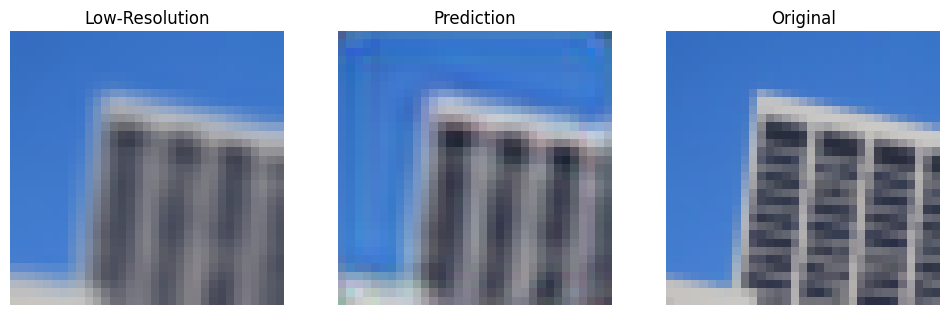

In [39]:
comparison1 = predict_and_evaluate(predict_folder, srcnn1, scale_factor=scale, index_image=1, input_size=(33, 33), print_average = False)
display_comparison(*comparison1[0])

Although the prediction seems to slightly better the quality of the patch, the predicted image's PSNR is lower than the PSNR relative to the bicubic interpolation upscale. This is because, as it's better shown in the next example, there are some artifacts in the edges and especially in the corners of the predicted image. This issue is caused by the parameter "padding='same'" in the convolutional layers, that keeps the input the same size as the output. The added padding, needed for this, causes this issue.

PSNR between LR and HR: 54.39 dB
PSNR between Predicted and HR: 35.82 dB


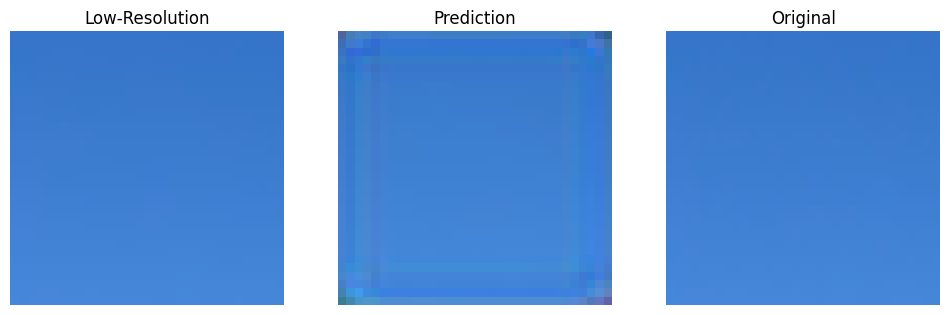

In [42]:
# Display one example
display_comparison(*comparisons1[3])

There are two ways to tackle this issue. The first method is the one in the following example, and it simply cuts the border (5 pixels, since the first convolutional layer's filter size was 9).

However, I don't think this is the best solution, since the mis-information of the edges might negatively impact the rest of the image, and the loss during training is also affected by this issue, so by using a different method I believe the issue could be better resolved.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
PSNR between LR and HR: 54.19 dB
PSNR between Predicted and HR: 40.33 dB


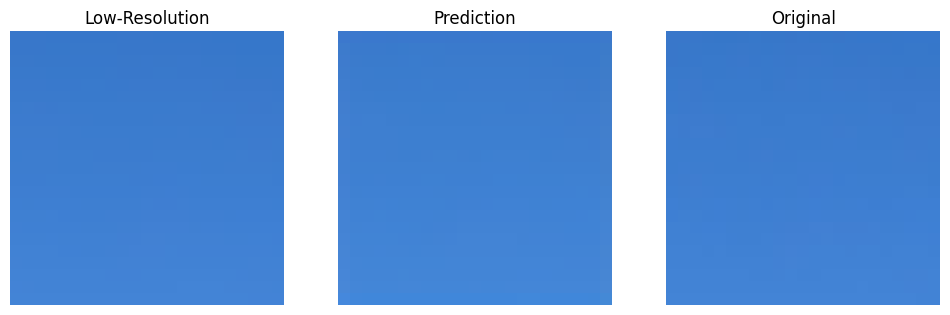

In [43]:
comparison1 = predict_and_evaluate(predict_folder, srcnn1, scale_factor=scale, index_image=3, input_size=(33, 33), remove_border=True, print_average=False)
display_comparison(*comparison1[0])

## Second SRCNN model

The second model shows the better solution to the problem of the artifacts around the edges of the image.

### Functions

The model is similar to the previous. The only difference is the padding 'valid', that will cut off the edges of the image already inside the model, automatically producing the smaller output (21x21 in this case, since the input is 33x33: the first layer reduces the spatial dimension to 25x25, the second layer keeps it the same, and the third layerredices it to 21x21).

In [29]:
def build_srcnn2():
    input_layer = Input(shape=(None, None, 3))  # Explicitly define the input layer
    x = Conv2D(64, (9, 9), activation='relu', padding='valid')(input_layer)
    x = Conv2D(32, (1, 1), activation='relu', padding='valid')(x)
    output_layer = Conv2D(3, (5, 5), activation='linear', padding='valid')(x)  # Linear activation for final layer

    model = tf.keras.Model(inputs=input_layer, outputs=output_layer)
    return model

Some changes had to be made to the predict_and_evalutate() function, to accomodate for an output size that is now different from the input size.

In [30]:
def predict_and_evaluate2(folder_path, model, scale_factor=2, num_images=None, hr_size=(33, 33), output_size=(33, 33), index_image=None, print_average=True):
    # Get list of image files in the folder, sorted by creation time
    image_files = sorted([os.path.join(folder_path, fname) for fname in os.listdir(folder_path) if fname.endswith(('.png', '.jpg', '.jpeg'))], key=os.path.getctime)
    # If num_images is specified, limit the number of images
    if num_images is not None:
        image_files = image_files[:num_images]
    # If index_image is specified, only evaluate that image
    if index_image is not None:
        image_files = [image_files[index_image]]

    psnrs_pred_hr = []
    psnrs_lr_hr = []
    comparisons = []

    for file in image_files:
        img = plt.imread(file)
        if img.shape[-1] == 4:  # Handle images with alpha channel by removing the transparency channel
            img = img[..., :3]
        lr, hr = preprocess_image(img, scale_factor=scale_factor, input_size=hr_size, output_size=output_size)

        pred = model.predict(np.expand_dims(lr, axis=0))[0] # Predict

        # Crop lr to match the pred size, for comparison purposes
        crop_x = (lr.shape[0] - pred.shape[0]) // 2
        crop_y = (lr.shape[1] - pred.shape[1]) // 2
        lr = lr[crop_x:crop_x + pred.shape[0], crop_y:crop_y + pred.shape[1]]

        # Calculate PSNR between predicted and HR images
        psnr_lr_hr = calculate_psnr(lr, hr)
        psnrs_lr_hr.append(psnr_lr_hr)
        psnr_pred_hr = calculate_psnr(pred, hr)
        psnrs_pred_hr.append(psnr_pred_hr)

        comparisons.append((lr, pred, hr))

    if print_average:
        print(f"Average PSNR between low resolution images (bicubic interpolation) and high-resolution images: {np.mean(psnrs_lr_hr):.2f} dB")
        print(f"Average PSNR between predicted images and high-resolution images: {np.mean(psnrs_pred_hr):.2f} dB")
    return comparisons

### Second model and evaluation

In [31]:
model_save_path = '/content/drive/My Drive/SRCNN Models/srcnn_model2.keras'
scale2 = 2

if os.path.exists(model_save_path):
    # Load the pre-trained model
    srcnn2 = load_model(model_save_path)
    print("Model loaded successfully.")
else:
    # Folder paths
    train_folder = train_path_destination
    test_folder = val_path_destination

    # Compile SRCNN model
    srcnn2 = build_srcnn2()
    srcnn2.compile(optimizer=Adam(learning_rate=1e-4), loss=MeanSquaredError())

    # Create data generators
    train_gen = data_generator(train_folder, batch_size=16, scale_factor=scale2, output_size=(21, 21))
    test_gen = data_generator(test_folder, batch_size=16, scale_factor=scale2, output_size=(21, 21))

    # Estimate steps per epoch
    num_train_images = len(os.listdir(train_folder))
    num_test_images = len(os.listdir(test_folder))
    train_steps = num_train_images // 16
    test_steps = num_test_images // 16

    # Train SRCNN
    history = srcnn2.fit(train_gen, validation_data=test_gen, steps_per_epoch=train_steps, validation_steps=test_steps, epochs=10)

    # Save the trained model
    srcnn2.save(model_save_path)

    print("SRCNN training complete and model saved.")

Model loaded successfully.


In [32]:
# Perform predictions and evaluations
predict_folder = test_path_destination
comparisons2 = predict_and_evaluate2(predict_folder, srcnn2, scale_factor=scale2, num_images=100, output_size=(21,21))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━

Thanks to the removal of the edges, the average PSNR has gotten better. Though it looks like if we compare it to a simple bicubic interpolation, it's slightly worse.

PSNR between LR and HR: 29.07 dB
PSNR between Predicted and HR: 29.25 dB


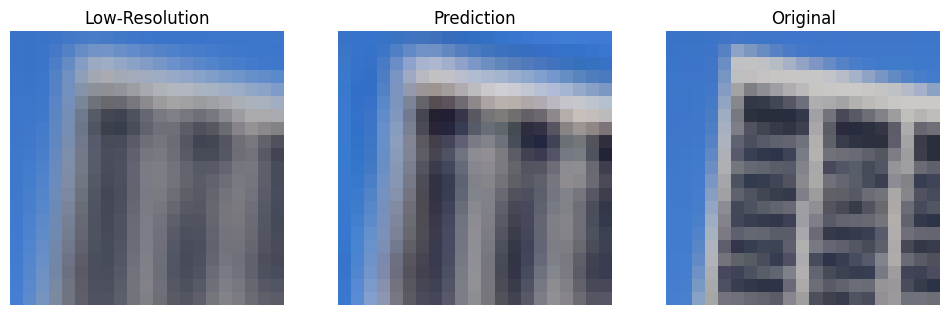

In [44]:
display_comparison(*comparisons2[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
PSNR between LR and HR: 54.21 dB
PSNR between Predicted and HR: 52.47 dB


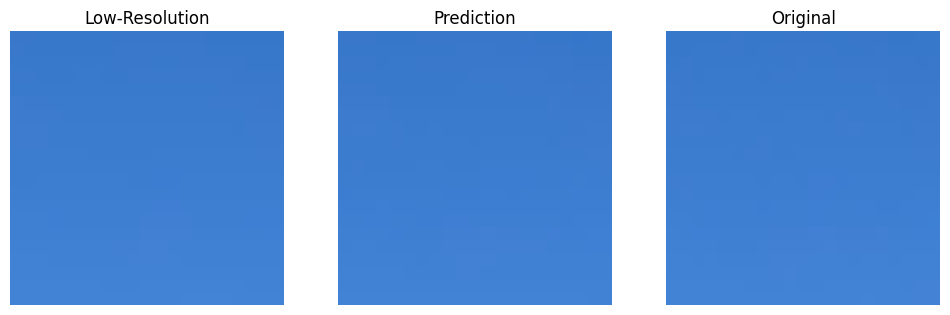

In [46]:
comparison2 = predict_and_evaluate2(predict_folder, srcnn2, scale_factor=scale2, index_image=3, output_size=(21,21), print_average=False)
display_comparison(*comparison2[0])

Though we can notice that the model is moving in the right direction with the prediction, I think the original image is too small and too "noisy" to be fully recreated.

The improvements are surely limited by the small and general dataset that is being used, but let's try to see if the improvements are more noticeable on bigger pictures.

PSNR between LR and HR: 28.68 dB
PSNR between Predicted and HR: 28.80 dB


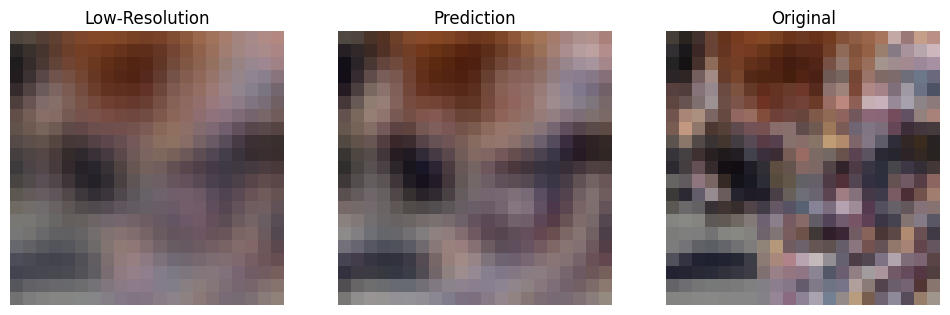

In [47]:
display_comparison(*comparisons2[45])

#### Before going to the next model...

I wanted to investigate better the reason why the average PSNR with the predicted images is slightly lower than the average PSNR with the bicubic interpolation, apart from the very general and small dataset that doesn't help of course.

I wanted to see if my assumptions about which images are causing this (I believe) false worse performance were correct.

These functions calculate the PSNR values and the 'total variance', that represents how much each image is uniform or has many different colors and varying intensities.

The PSNR and the variances are then plotted in a dot plot.

In [129]:
# Function to calculate variance score (using standard deviation of pixel values)
def total_variance(image):
    if image.ndim == 3:  # Convert to grayscale if it's a color image
        image = np.mean(image, axis=-1)
    return np.var(image)  # Higher variance indicates more detail

# Function to process output of the 'predict_and_evaluate2' and calculate variance score
def calculate_psnr_and_variance(comparisons):
    result_list = []

    for lr, pred, hr in comparisons:
        # Calculate PSNR between LR and HR
        psnr_lr_hr = calculate_psnr(lr, hr)
        # Calculate PSNR between Predicted and HR
        psnr_pred_hr = calculate_psnr(pred, hr)
        # Calculate variance scores for each image
        variance_lr = total_variance(lr)
        variance_pred = total_variance(pred)
        variance_hr = total_variance(hr)

        # Append the results to the list
        result_list.append((lr, pred, hr, psnr_lr_hr, psnr_pred_hr, variance_lr, variance_pred, variance_hr))

    return result_list

# Function to plot PSNR vs Variance score with index labels and connections
def plot_psnr_vs_variance(result_list, filter_psnr_threshold=None):
    psnr_lr_hr_values = []  # Initialize an empty list for PSNR values (LR vs HR)
    psnr_pred_hr_values = []  # Initialize an empty list for PSNR values (Predicted vs HR)
    variance_hr_values = []  # Initialize an empty list for variance values (Predicted)
    indices = []  # Initialize an empty list for indices

    # Extract PSNR, variance, and indices for predicted images
    for idx, (lr, pred, hr, psnr_lr_hr, psnr_pred_hr, variance_lr, variance_pred, variance_hr) in enumerate(result_list):
        # Check if the PSNR values exceed the threshold (if specified)
        if filter_psnr_threshold is None or psnr_pred_hr > filter_psnr_threshold:
            psnr_lr_hr_values.append(psnr_lr_hr)  # Append the PSNR (LR vs HR) value
            psnr_pred_hr_values.append(psnr_pred_hr)  # Append the PSNR (Predicted vs HR) value
            variance_hr_values.append(variance_hr)  # Append the variance value
            indices.append(idx)  # Store the index

    # Create a scatter plot
    plt.figure(figsize=(16, 8))

    # Plot PSNR for LR vs HR as red dots
    plt.scatter(psnr_lr_hr_values, variance_hr_values, color='red', label='LR vs HR (PSNR)', zorder=3)

    # Plot PSNR for Predicted vs HR as blue dots
    plt.scatter(psnr_pred_hr_values, variance_hr_values, color='blue', label='Predicted vs HR (PSNR)', zorder=3)

    # Annotate each point with its index
    for i, index in enumerate(indices):
        plt.annotate(str(index), (psnr_pred_hr_values[i], variance_hr_values[i]),
                     textcoords="offset points", xytext=(0, 5), ha='center', fontsize=9, color='black')

        # Draw a line connecting the LR vs HR dot and Predicted vs HR dot
        plt.plot([psnr_lr_hr_values[i], psnr_pred_hr_values[i]], [variance_hr_values[i], variance_hr_values[i]],
                 color='gray', linestyle='--', linewidth=1)

    plt.title('PSNR vs Variance Score with Connections')
    plt.xlabel('PSNR [dB]')
    plt.ylabel('Variance Score (Predicted)')
    plt.grid(True)
    plt.legend()
    plt.show()

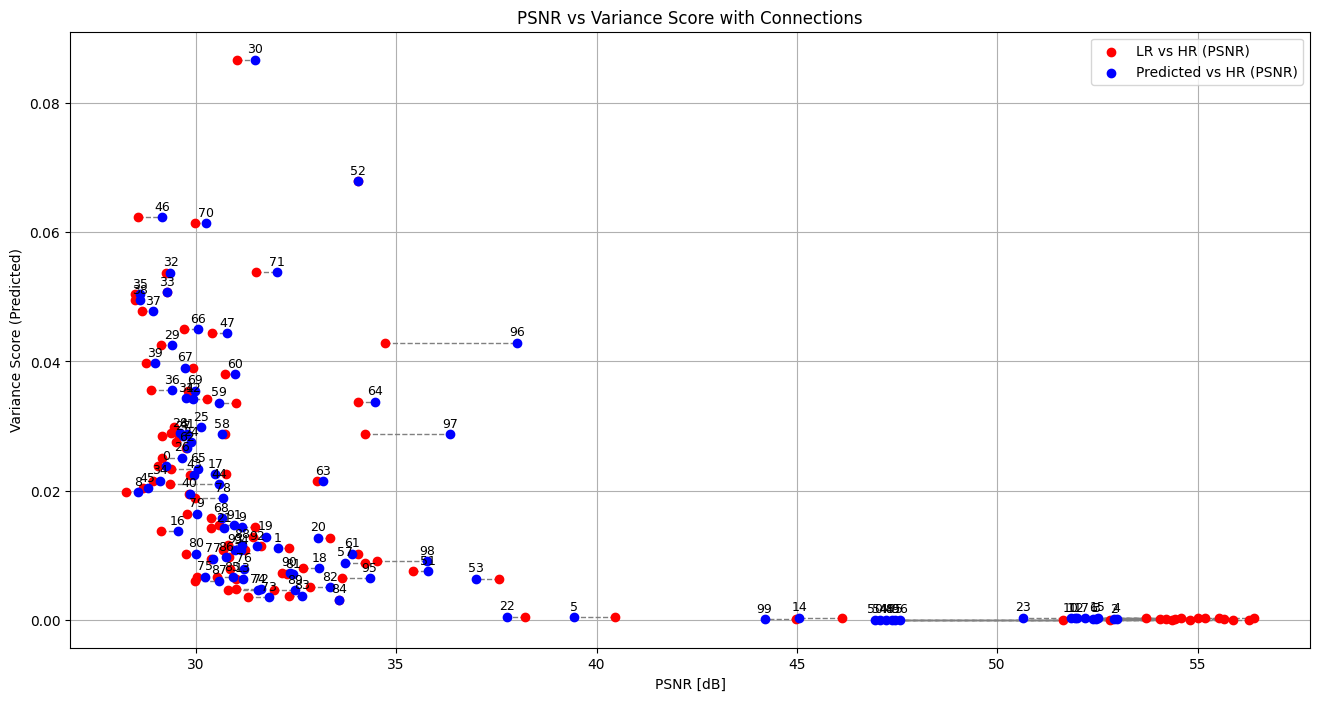

In [130]:
result_list = calculate_psnr_and_variance(comparisons2)
plot_psnr_vs_variance(result_list)

Let's zoom in the bottom right, to better read the indexes of those images.

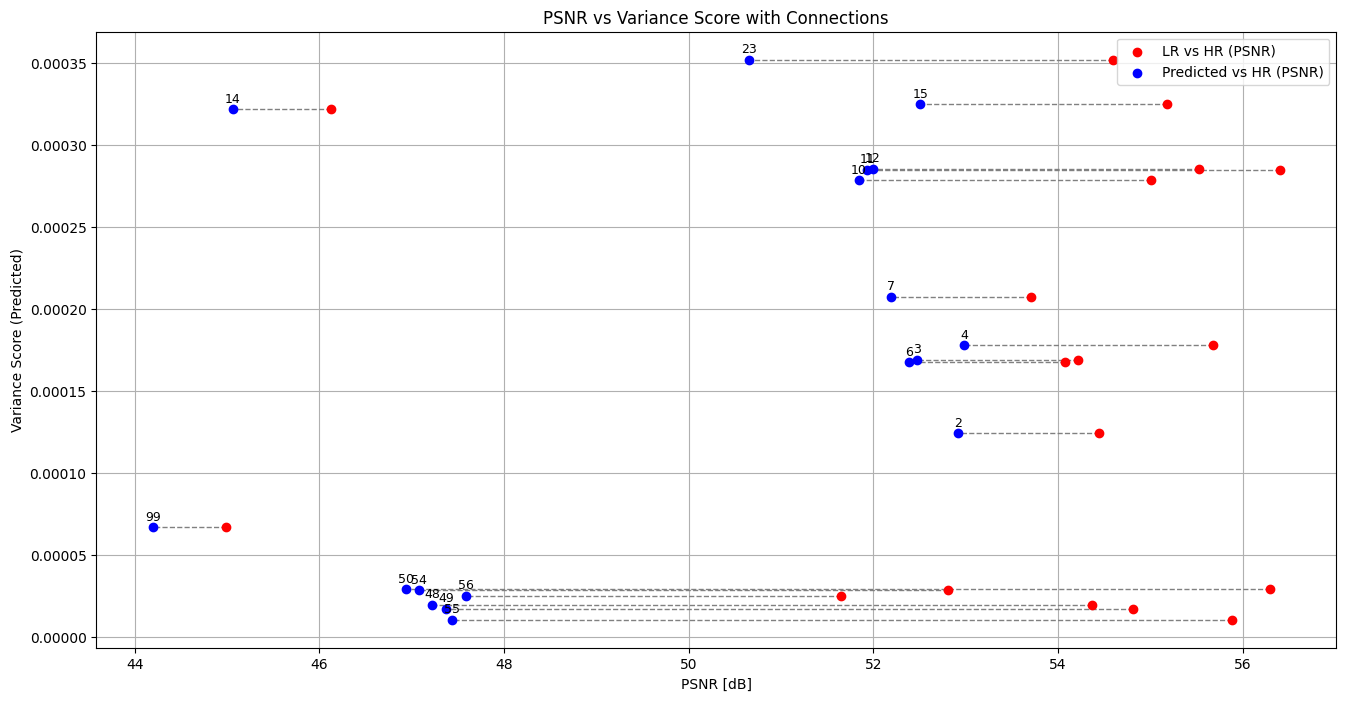

In [131]:
plot_psnr_vs_variance(result_list, filter_psnr_threshold=42)

PSNR between LR and HR: 55.88 dB
PSNR between Predicted and HR: 47.44 dB


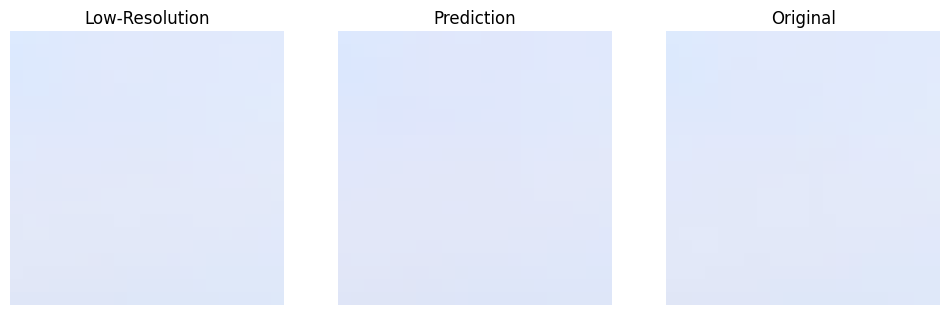

In [119]:
display_comparison(*comparisons2[55])

PSNR between LR and HR: 55.67 dB
PSNR between Predicted and HR: 52.98 dB


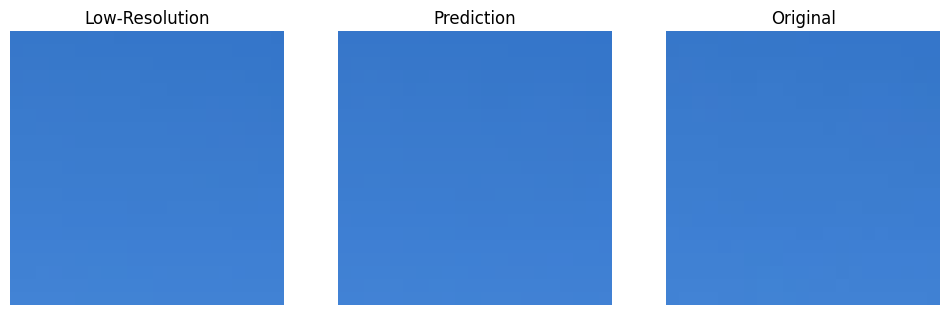

In [120]:
display_comparison(*comparisons2[4])

PSNR between LR and HR: 55.53 dB
PSNR between Predicted and HR: 51.99 dB


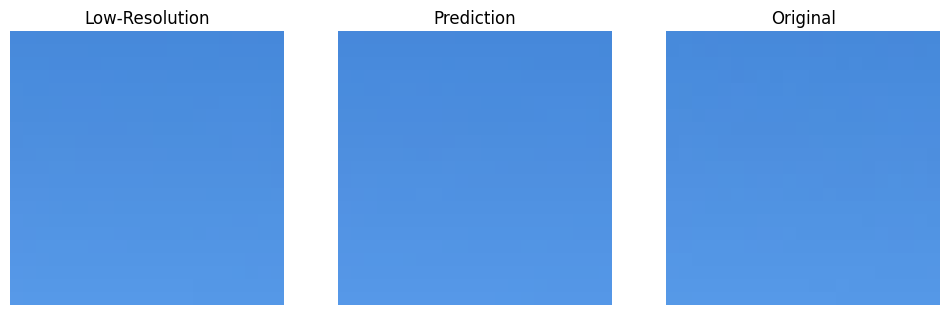

In [121]:
display_comparison(*comparisons2[12])

As expected, the images with the biggest PSNR difference are those where the PSNR value is very high and the variance is very low.

This is because the predicted image shifts each pixel's color very slightly, resulting in a worse PSNR, compared to the bicubic interpolation that keeps exactly the same shade of color.

Let's now see other interesting images.

PSNR between LR and HR: 34.23 dB
PSNR between Predicted and HR: 36.34 dB


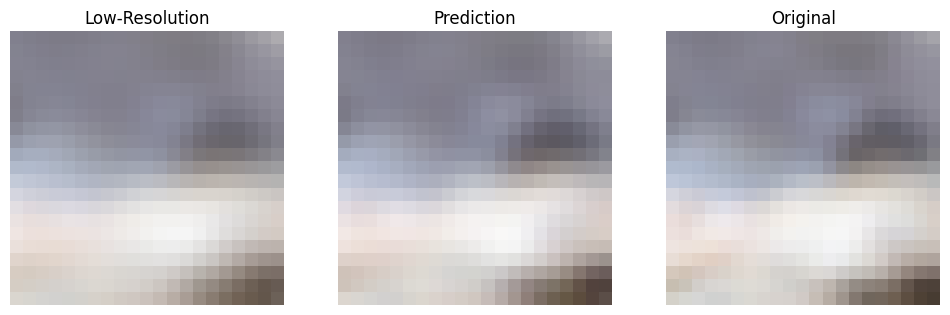

In [122]:
display_comparison(*comparisons2[97])

PSNR between LR and HR: 34.71 dB
PSNR between Predicted and HR: 38.01 dB


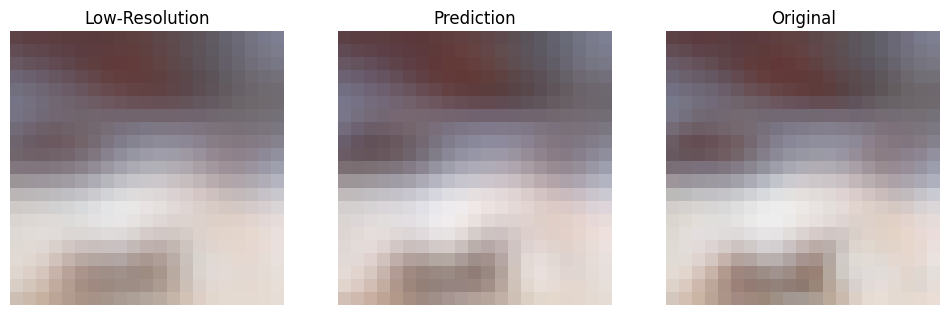

In [123]:
display_comparison(*comparisons2[96])

PSNR between LR and HR: 28.65 dB
PSNR between Predicted and HR: 28.92 dB


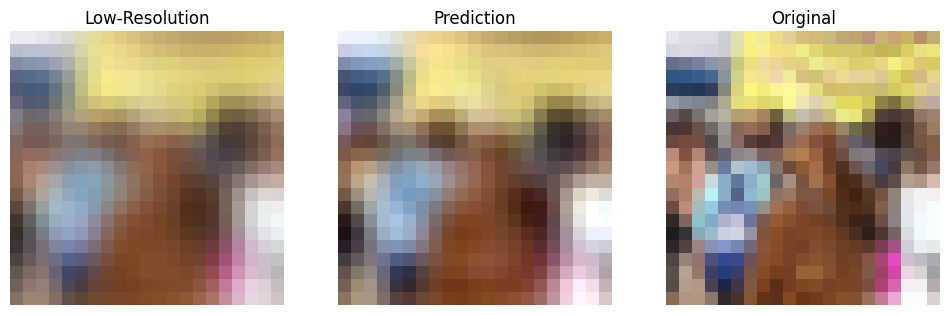

In [126]:
display_comparison(*comparisons2[37])

PSNR between LR and HR: 28.68 dB
PSNR between Predicted and HR: 28.80 dB


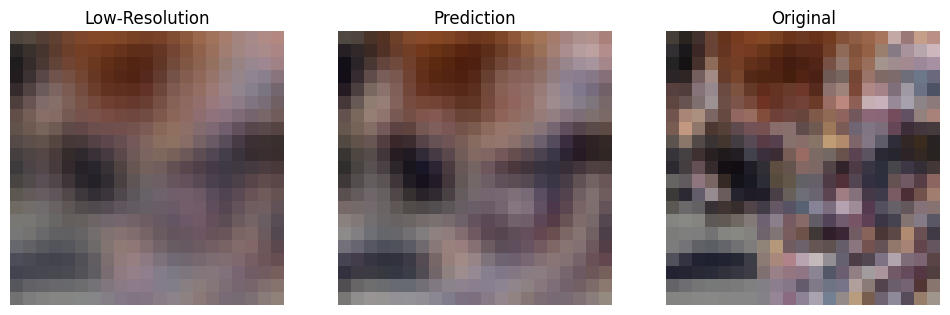

In [127]:
display_comparison(*comparisons2[45])

PSNR between LR and HR: 28.27 dB
PSNR between Predicted and HR: 28.55 dB


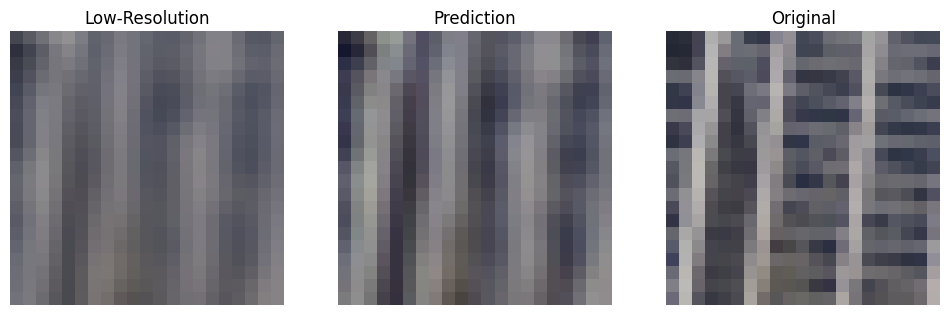

In [128]:
display_comparison(*comparisons2[8])

It seems like the patches that perform better are the patches where the colors are more smooth and predictable, while patches that have abrupt changes in very close pixels are harder to predict. Of course this makes sense, and could be mitigated by better downsampling mechanisms. I will not get into this too much though, since the original images themselves could have been downsized without my knowledge and that is something I cannot control, and it would take too much time to carefully prepare a dataset and perform all the tests on the downsizings.

In [132]:
def average_psnr_excluding(result_list, psnr_threshold):
    psnr_lr_hr_values = []
    psnr_pred_hr_values = []

    for lr, pred, hr, psnr_lr_hr, psnr_pred_hr, variance_lr, variance_pred, variance_hr in result_list:
        # Exclude images where PSNR is above the threshold
        if psnr_lr_hr <= psnr_threshold:
            psnr_lr_hr_values.append(psnr_lr_hr)
        if psnr_pred_hr <= psnr_threshold:
            psnr_pred_hr_values.append(psnr_pred_hr)

    # Calculate averages if there are valid values
    avg_psnr_lr_hr = np.mean(psnr_lr_hr_values) if psnr_lr_hr_values else None
    avg_psnr_pred_hr = np.mean(psnr_pred_hr_values) if psnr_pred_hr_values else None

    return avg_psnr_lr_hr, avg_psnr_pred_hr

In [133]:
avg_psnr_lr_hr, avg_psnr_pred_hr = average_psnr_excluding(result_list, 42)
print("Average PSNR (LR-HR):", avg_psnr_lr_hr)
print("Average PSNR (Pred-HR):", avg_psnr_pred_hr)

Average PSNR (LR-HR): 31.09883118704636
Average PSNR (Pred-HR): 31.37032209428515


If I exclude those images with very low variance and very high PSNR, the results of the model are (finally) better.

# Other models to fix

In [36]:
model_save_path = '/content/drive/My Drive/SRCNN Models/srcnn_model2.keras'
scale = 2

if os.path.exists(model_save_path):
    # Load the pre-trained model
    srcnn2 = load_model(model_save_path)
    print("Model loaded successfully.")
else:
    # Folder paths
    train_folder = train_path_destination
    test_folder = val_path_destination

    # Compile SRCNN model
    srcnn2 = build_srcnn()
    srcnn2.compile(optimizer=Adam(learning_rate=1e-4), loss=MeanSquaredError())

    # Create data generators
    train_gen = data_generator(train_folder, batch_size=16, scale=scale, hr_size=(256, 256))
    test_gen = data_generator(test_folder, batch_size=16, scale=scale, hr_size=(256, 256))

    # Estimate steps per epoch
    num_train_images = len(os.listdir(train_folder))
    num_test_images = len(os.listdir(test_folder))
    train_steps = num_train_images // 16
    test_steps = num_test_images // 16

    # Train SRCNN
    history = srcnn2.fit(train_gen, validation_data=test_gen, steps_per_epoch=train_steps, validation_steps=test_steps, epochs=10)

    # Save the trained model
    srcnn2.save(model_save_path)

    print("SRCNN training complete and model saved.")

Model loaded successfully.


In [37]:
# Perform predictions and evaluations
predict_folder = test_path_destination
comparisons = predict_and_evaluate(predict_folder, srcnn2, scale_factor=scale, num_images=100, hr_size=(256, 256))

TypeError: predict_and_evaluate() got an unexpected keyword argument 'hr_size'

In [ ]:
# Display one example
display_comparison(*comparisons[0])

In [ ]:
comparison = predict_and_evaluate(predict_folder, srcnn2, scale_factor=scale, index_image=2, hr_size=(256, 256))
display_comparison(*comparison[0])

In [ ]:
model_save_path = '/content/drive/My Drive/SRCNN Models/srcnn_model3.keras'
scale = 3

if os.path.exists(model_save_path):
    # Load the pre-trained model
    srcnn3 = load_model(model_save_path)
    print("Model loaded successfully.")
else:
    # Folder paths
    train_folder = train_path_destination
    test_folder = val_path_destination

    # Compile SRCNN model
    srcnn3 = build_srcnn()
    srcnn3.compile(optimizer=Adam(learning_rate=1e-4), loss=MeanSquaredError())

    # Create data generators
    train_gen = data_generator(train_folder, batch_size=16, scale=scale, hr_size=(256, 256))
    test_gen = data_generator(test_folder, batch_size=16, scale=scale, hr_size=(256, 256))

    # Estimate steps per epoch
    num_train_images = len(os.listdir(train_folder))
    num_test_images = len(os.listdir(test_folder))
    train_steps = num_train_images // 16
    test_steps = num_test_images // 16

    # Train SRCNN
    history = srcnn3.fit(train_gen, validation_data=test_gen, steps_per_epoch=train_steps, validation_steps=test_steps, epochs=10)

    # Save the trained model
    srcnn3.save(model_save_path)
    print("SRCNN training complete and model saved.")

In [ ]:
# Perform predictions and evaluations
predict_folder = test_path_destination
comparisons = predict_and_evaluate(predict_folder, srcnn3, scale=scale, num_images=100, hr_size=(256, 256))

In [ ]:
# Display one example
display_comparison(*comparisons[0])

In [ ]:
comparison = predict_and_evaluate(predict_folder, srcnn3, scale=scale, index_image=2, hr_size=(256, 256))
display_comparison(*comparison[0])